# Credit Card Default Clients in Taiwan Analysis

Trying to predict the likelihood of credit card default for clients in Taiwan, dataset provided by UCI (https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

## Motivation

In a well-developed financial system, effective crisis management and robust risk prediction are critical components. Risk prediction aims to utilize financial information, such as business financial statements, customer transactions, and repayment records, to forecast business performance or individual customers' credit risk, thereby reducing potential damage and uncertainty.

Beginning in 1990, the Taiwanese government allowed the formation of new banks. Initially, these banks focused on lending large sums to real estate companies. However, as the real estate market became saturated, these banks shifted their focus to credit cards and cash cards. They aggressively issued credit cards, often lowering approval requirements to attract more customers, including young people with insufficient income. This resulted in widespread overuse of credit cards, leading to significant debt accumulation. By February 2006, debt from credit cards and cash cards in Taiwan had reached $268 billion USD, with over half a million people unable to repay their loans, becoming "credit card slaves." This term refers to individuals who can only pay the minimum balance on their credit card debt each month. The societal repercussions were severe, including increased suicide rates, homelessness, inability to afford education, and engagement in illegal activities to repay debts. The Taiwanese government was compelled to address these issues to stabilize the financial system and mitigate further societal problems.

This project aims to develop a reliable predictive model to identify individuals likely to default on their credit cards. By leveraging client information and historical transaction data, our goal is to create an automated system capable of pinpointing key factors contributing to credit card defaults. Such a model would enable banks to proactively address potential defaults by offering alternative solutions, such as forbearance or debt consolidation, thereby mitigating losses and supporting customers in managing their financial obligations.

Growing up in Taiwan, I witnessed firsthand the changes in the financial sector and the impact these changes had on people's lives. My personal connection to Taiwan has motivated me to work on projects that address the challenges faced by banks and cardholders, aiming to create a more secure and reliable financial environment.

###  Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score,precision_recall_fscore_support, ConfusionMatrixDisplay


## Data Preprocessing 

In [27]:
warnings.filterwarnings('ignore')
df = pd.read_excel("default of credit card clients.xls")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [28]:
# Data Cleaning delete id column as it is not useful to our analysis
df.drop('ID', axis=1, inplace=True)

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
This study reviewed the literature and used the following 23 variables as explanatory variables:

**LIMIT_BAL** : Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

**SEX**: Gender (1 = male; 2 = female).

**EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).

**AGE**: Age (year).

**PAY_0 - PAY_6**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- PAY_0 = the repayment status in September, 2005; 
- PAY_1 = the repayment status in August, 2005; . . .;
- PAY_6 = the repayment status in April, 2005. 
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

**BILL_AMT1 - BILL_AMT6**: Amount of bill statement (NT dollar).
- X12 = amount of bill statement in September, 2005; 
- X13 = amount of bill statement in August, 2005; . . .;
- X17 = amount of bill statement in April, 2005. 

**PAY_AMT1 - PAY_AMT6**: Amount of previous payment (NT dollar). 
- X18 = amount paid in September, 2005; 
- X19 = amount paid in August, 2005; . . .;
- X23 = amount paid in April, 2005.

In [29]:
# Transposed to see all variables.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


We can see that there are **30,000 clients** in dataset, with an average of **NTD 167484 ( ~ 5193 USD given current exchange rate 25 MAY 2024)** in balance and an average age of **35.5** years old. Also with gender being 1.6, this data set has a greater percentage of women compared to men. 

### Renaming variables:
Renamed the colum default payment next month to Default for sake of simplicity

In [30]:

df.rename(columns={"default payment next month": "Default"}, inplace = True)
df.columns


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default'],
      dtype='object')

## Cleaning Data

**EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others).

If we look at education and marraige specifically, we can see that there are numbers there that don't match the description we were given from above:

In [31]:
print("EDUCATION UNIQUE: ", df.EDUCATION.unique())
print("MARRIAGE UNIQUE: ", df.MARRIAGE.unique())

EDUCATION UNIQUE:  [2 1 3 5 4 6 0]
MARRIAGE UNIQUE:  [1 2 3 0]


We will assume the numbers that are incorreclty labeled fall under the 'others' description 

In [32]:
df['EDUCATION'].replace({0:4,5:4,6:4}, inplace=True) #All 0's 5's and 6's will be replaced by 4
df['MARRIAGE'].replace({0:3}, inplace=True) # All 0's will be replaced with 3 

We also have to scale our data and impute any missing values, so that certain variables don't have a larger impact on our result based soley on their relative scale:

## EDA - Correlation Analysis 
Let's see which variables are correlated with each other:

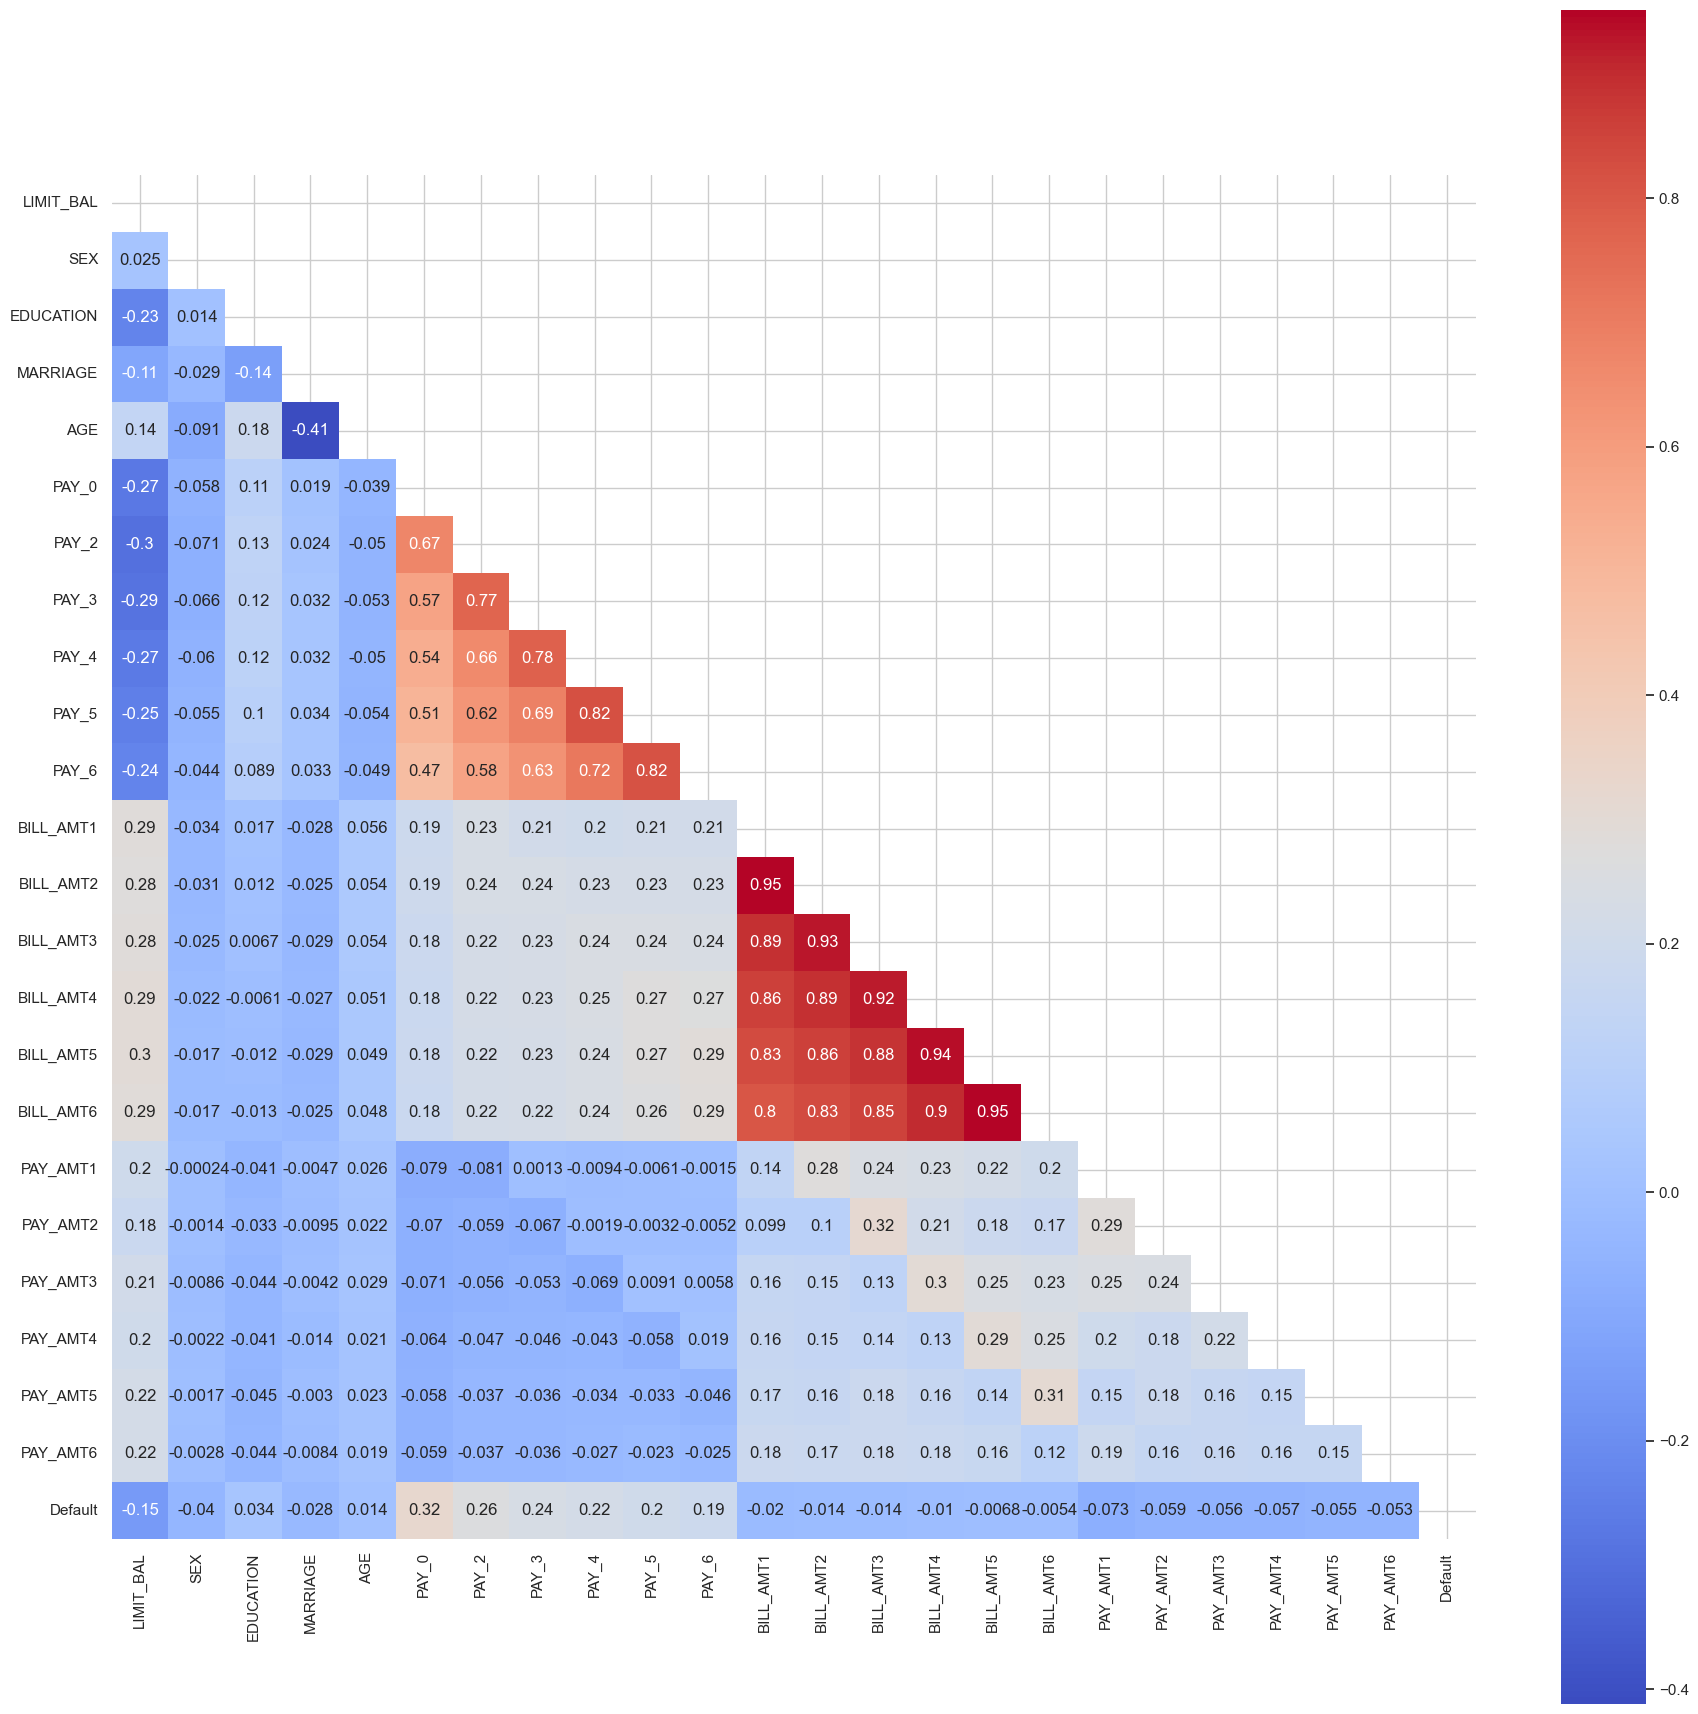

In [33]:
plt.figure(figsize = (22,22))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix,annot = True,square = True, cmap='coolwarm',mask=np.triu(correlation_matrix)) 
plt.show()

Red colors indicate higher correlation, which we see with the payments (PAY_0 - PAY_6) and the bill amounts (BILL_AMT1). 

This is problematic because having highly correlated features provide redundant information, which does not add any new insights to the model. This redundancy can lead to an increase in the complexity of the model without improving its predictive power. 

Highly correlated features can also cause multicollinearity, where the independent variables are highly correlated with each other. This can make it difficult to determine the individual effect of each feature on the target variable, leading to unstable and unreliable estimates of regression coefficients. In the presence of multicollinearity, small changes in the data can cause large variations in the model parameters. This sensitivity can result in models that generalize poorly to new, unseen data, reducing the robustness and reliability of our predictions.

Models with highly correlated features are also prone to overfitting. Overfitting occurs when the model captures the noise in the training data rather than the underlying pattern, leading to poor performance on test data. 

Let's also examine which vriables are the most correlated with our output (Default).

In [34]:
correlations = correlation_matrix['Default'].drop('Default')
top_10_correlated = correlations.abs().sort_values(ascending=False).head(10)
print("Top 10 most correlated variables to 'Default':")
print(top_10_correlated)

Top 10 most correlated variables to 'Default':
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
LIMIT_BAL    0.153520
PAY_AMT1     0.072929
PAY_AMT2     0.058579
PAY_AMT4     0.056827
Name: Default, dtype: float64


It seems like that past monthly payments are the most correlated with our output variable, which makes sense as it is common knowledge that paying your credit card payments on time is a way to boost your credit score. It will also be interesting to see if these variables will be the principal components that make up our models later on.

## Feature Engineering

In [35]:
num_features = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] # numerical features
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']# categorical features
print("Numerical Features: ", num_features)
print("Categorical Features: ", cat_features)

Numerical Features:  ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Categorical Features:  ['SEX', 'EDUCATION', 'MARRIAGE']


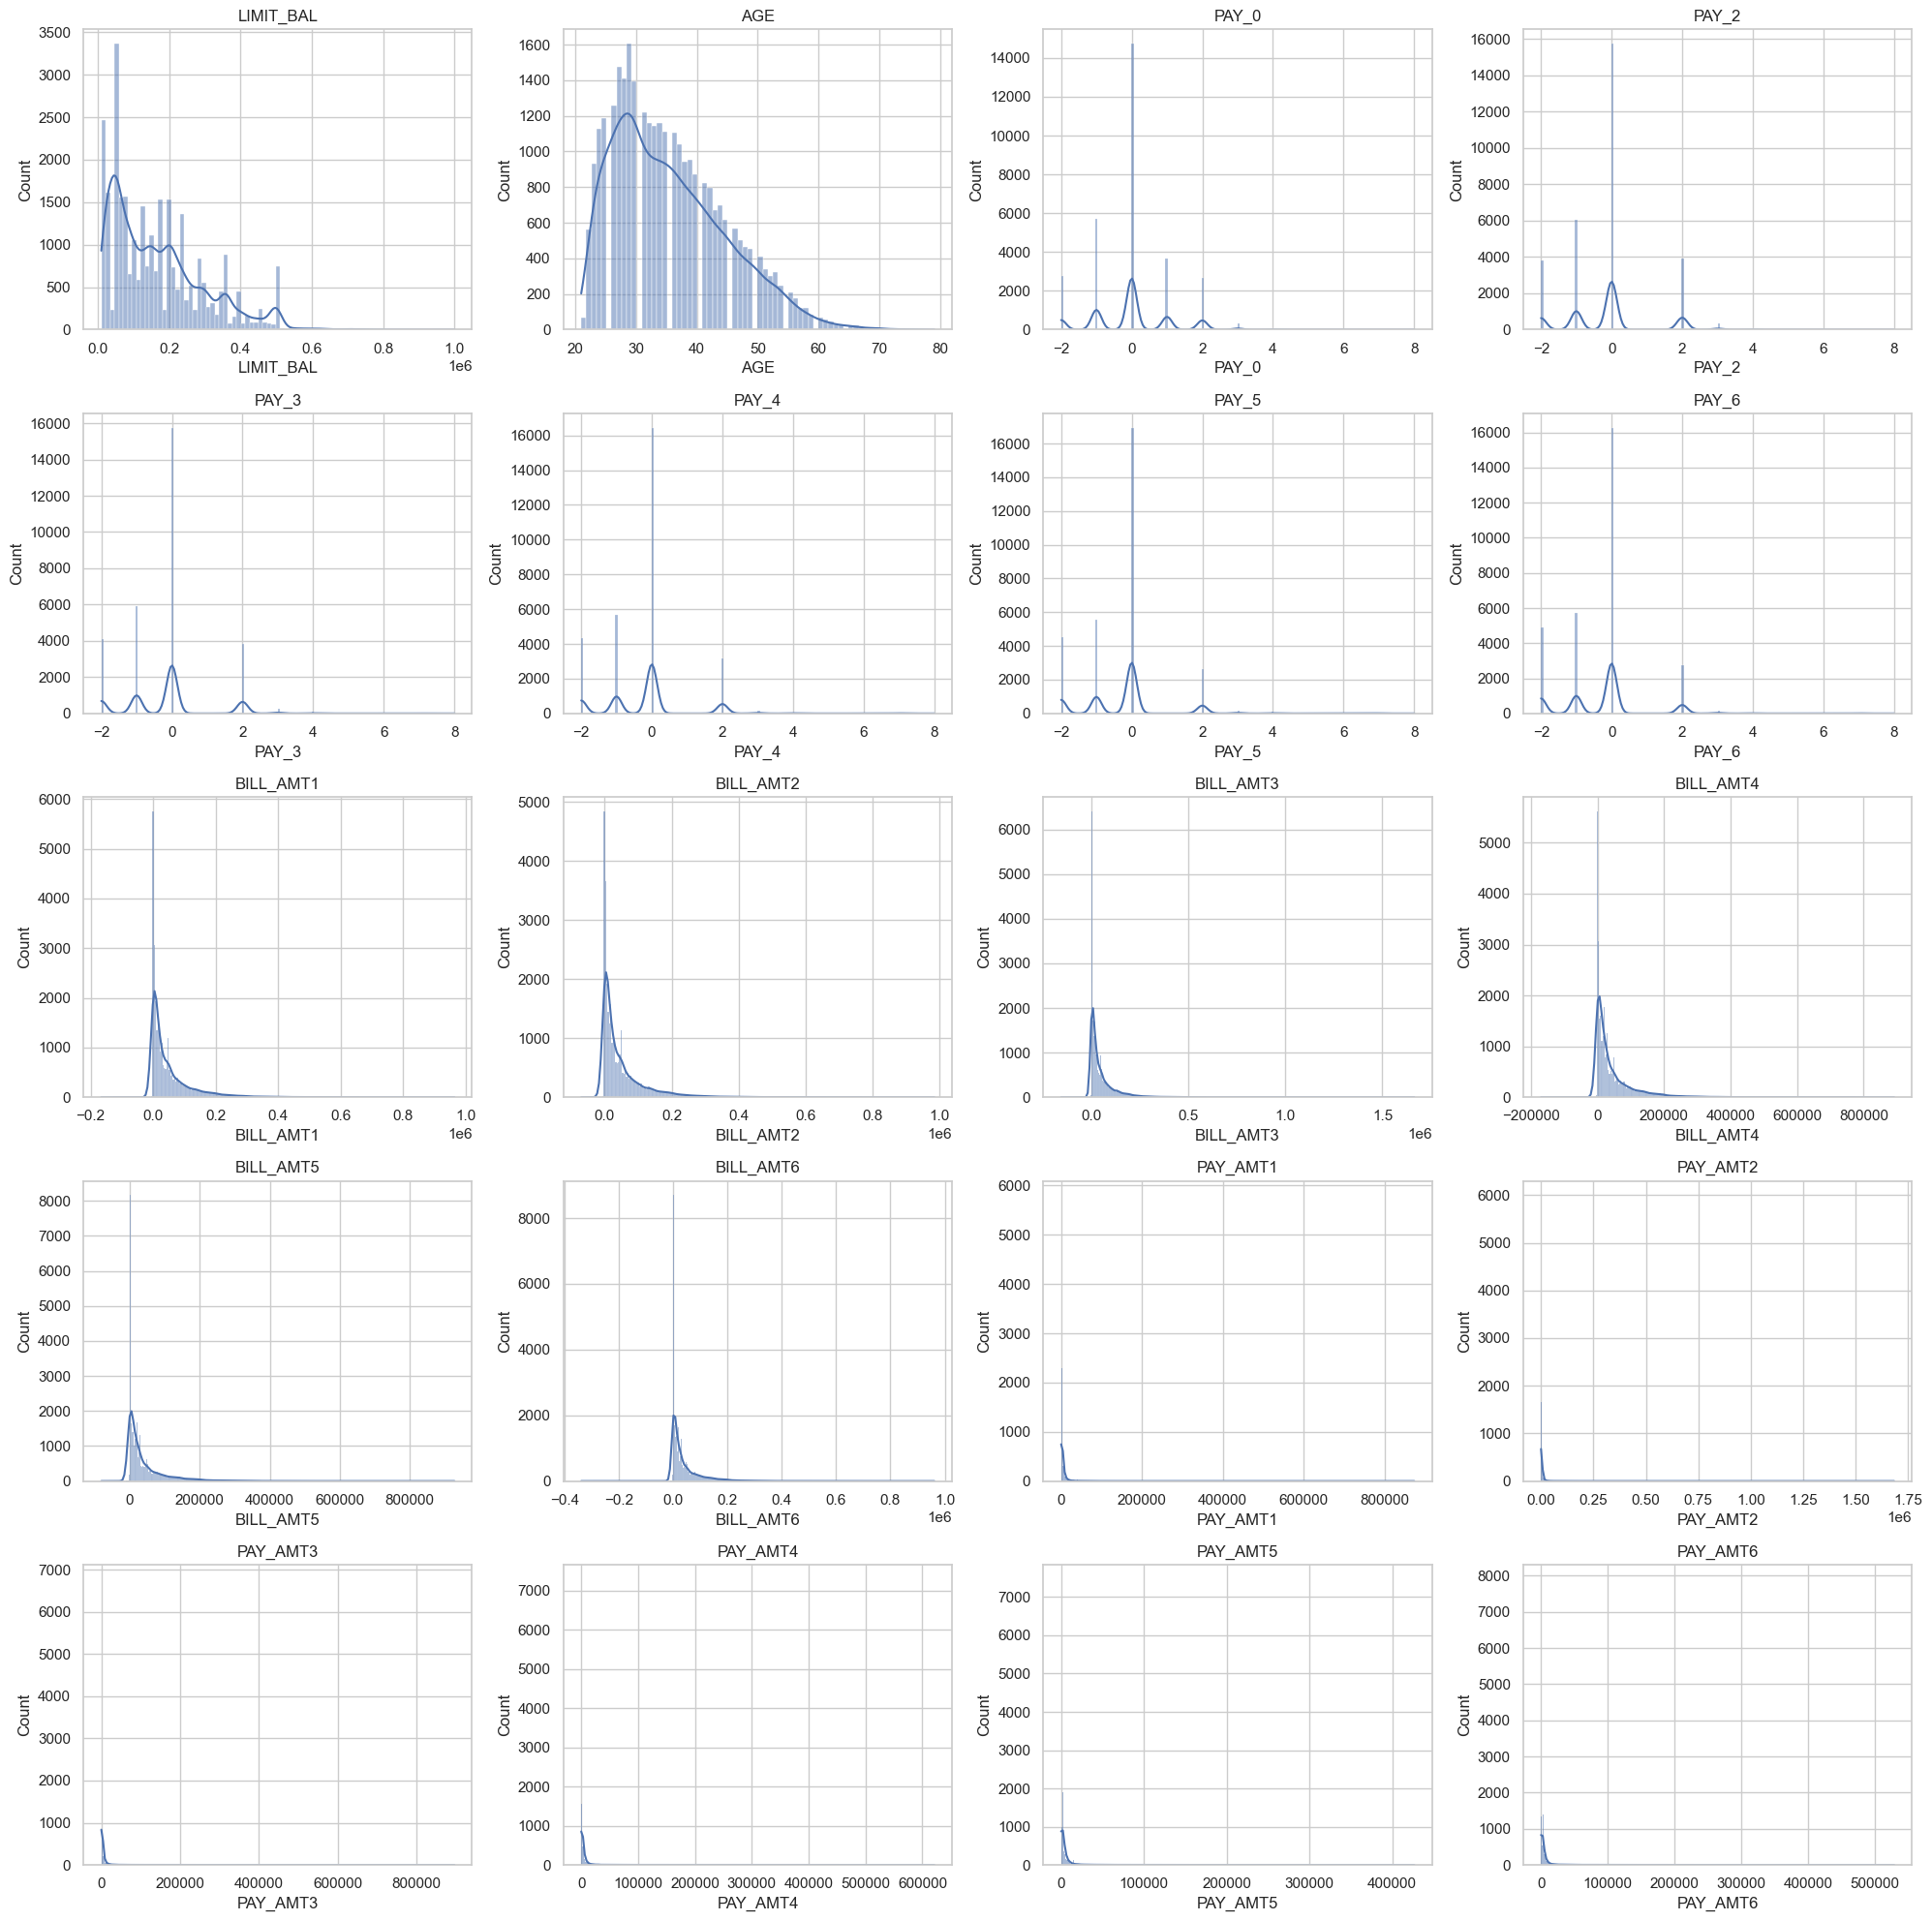

In [36]:
# examine the distributions of the features
plt.figure(figsize=(20, 20))
for i, feature in enumerate(num_features):
    plt.subplot(5, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


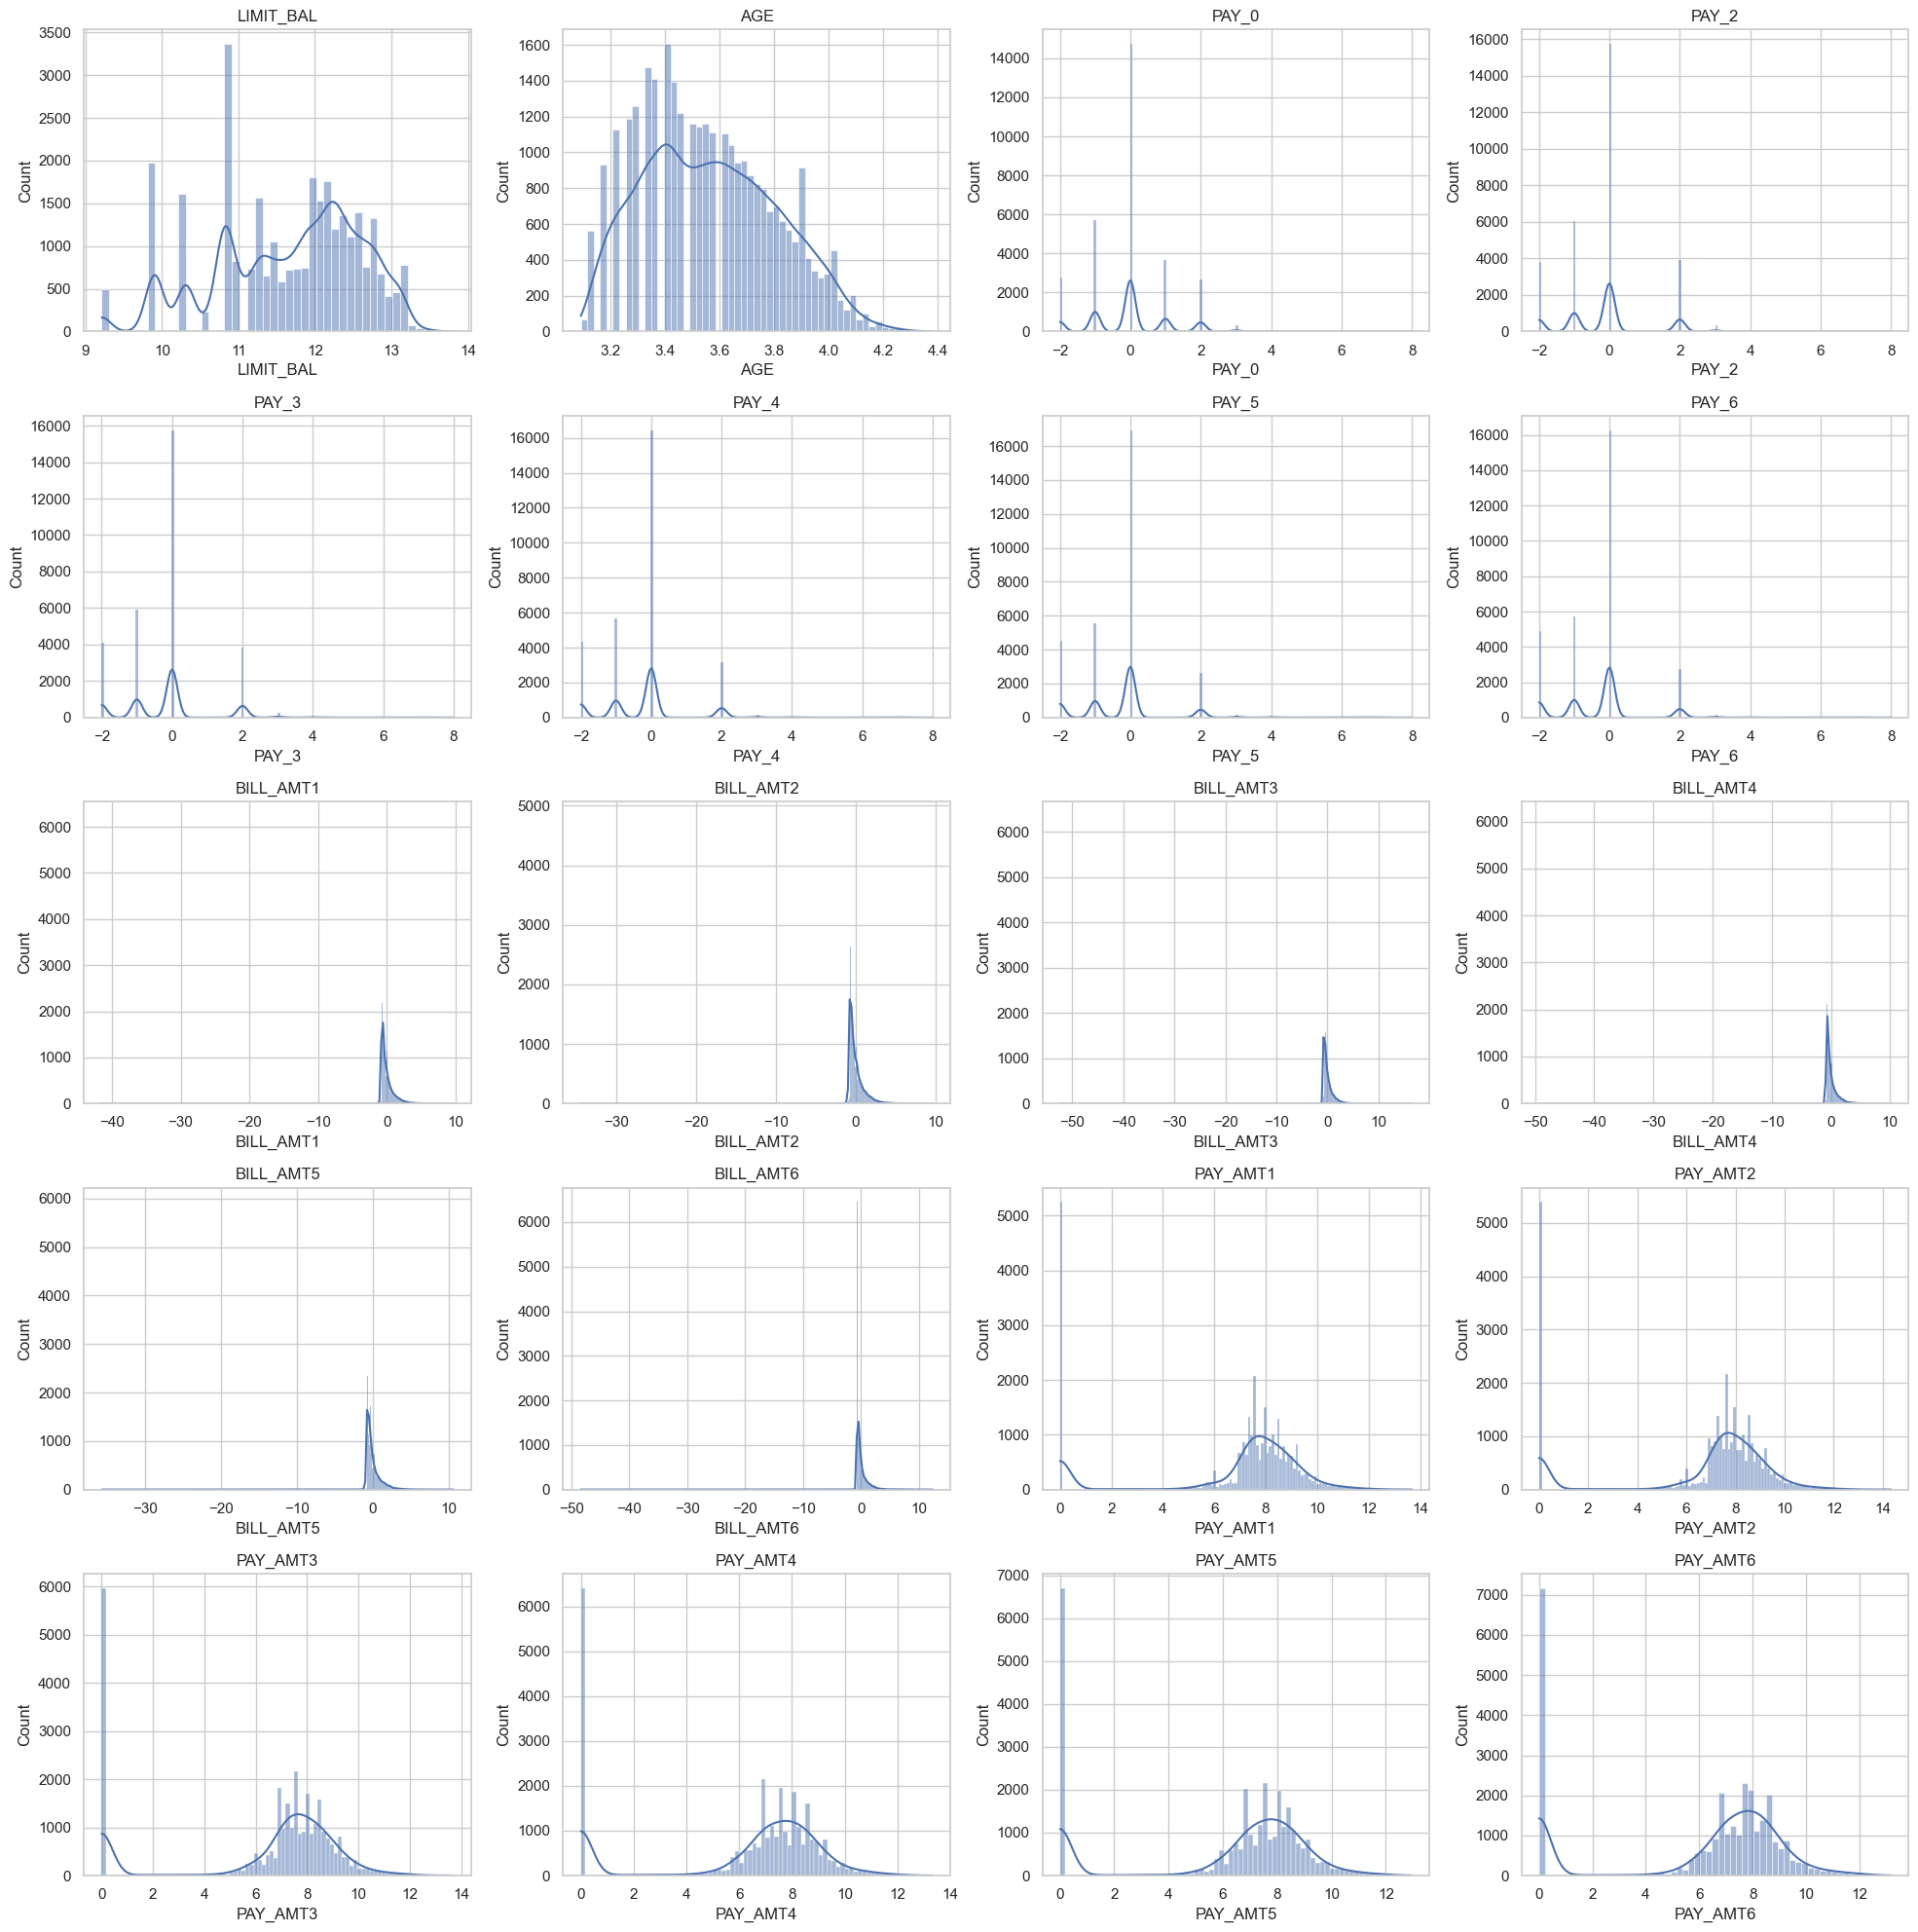

In [37]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']] = pt.fit_transform(df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']])


# log transform the features with right-skewed distributions
right_skewed_features = ['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for feature in right_skewed_features:
    df[feature] = np.log1p(df[feature])

# examine the distributions of the features after log transformation
plt.figure(figsize=(20, 20))
for i, feature in enumerate(num_features):
    plt.subplot(5, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

## Data Visualization

### Defaulters Imbalance

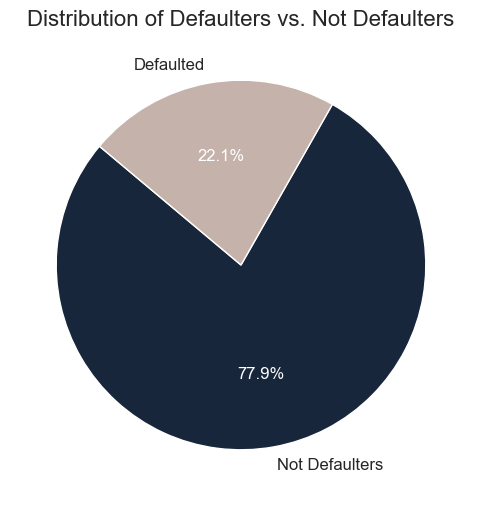

In [38]:

counts = df['Default'].value_counts()
labels = ["Not Defaulters", "Defaulted"]
colors = ["#17263a", "#c5b2aa"]

def make_autopct(colors):
    def inner_autopct(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    return inner_autopct

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct=make_autopct(colors), startangle=140, colors=colors, textprops={'fontsize': 12})

for autotext in autotexts:
    autotext.set_color('white')

plt.title("Distribution of Defaulters vs. Not Defaulters", fontsize=16)

plt.show()


Only about 22.1% of our data set are those who default, which means our model should be at least 77.9% accurate or else it is pretty much useless (classifier that predicts everyone to be non-defaulters would be accurate 77.9%).

### Gender Imbalance

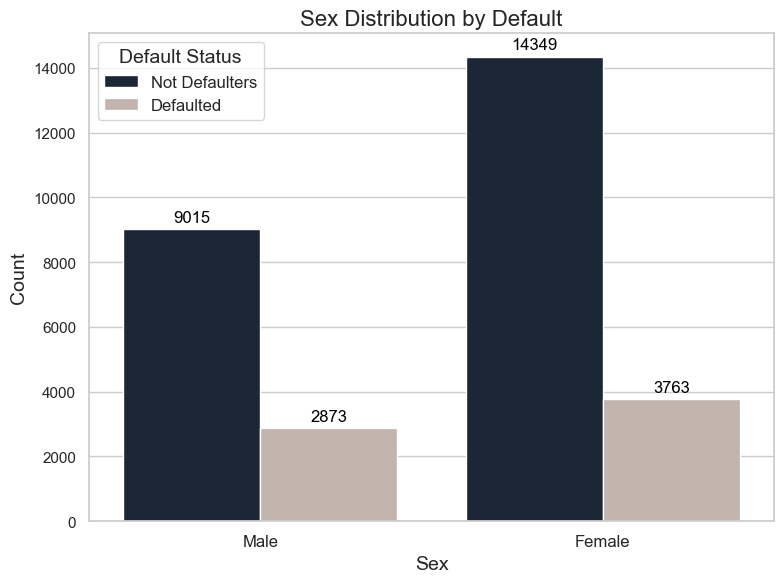

In [39]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x="SEX", hue="Default", palette=colors)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=12, color='black', padding=3)

plt.xticks([0, 1], labels=["Male", "Female"], fontsize=12)
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Sex Distribution by Default", fontsize=16)

legend_labels = ["Not Defaulters", "Defaulted"]
ax.legend(title="Default Status", labels=legend_labels, fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

There are more females than males who own a credit card in our dataset, and a smaller percentage default on their credit card compared to their male counterparts.

### Education Imbalance

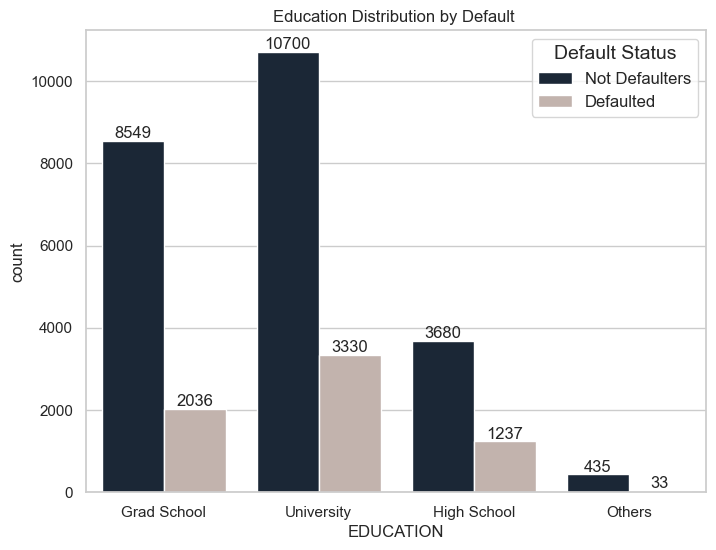

In [40]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=df, x="EDUCATION", hue="Default", palette=colors)
for label in ax.containers:
    ax.bar_label(label)
plt.xticks([0,1,2,3], labels=["Grad School", "University",'High School','Others'])
plt.title("Education Distribution by Default ")
ax.legend(title="Default Status", labels=legend_labels, fontsize=12, title_fontsize=14)
plt.show()

University students are the group which highest number customers using credit cards, followed by grad students and then high school students.
It seems like in terms of percentage, high school students have the highest percentage of defaults.



## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that is necessary for several reasons in data analysis and machine learning:

High-dimensional datasets often contain a large number of features, many of which might be redundant or irrelevant. PCA helps reduce the dimensionality of the data by transforming it into a smaller set of uncorrelated variables, called principal components, which capture the most significant variance in the data.

Reducing the number of features simplifies the models and decreases computational requirements. This is particularly important for algorithms that are computationally intensive and may suffer from the ["curse of dimensionality."](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

In [41]:
X = df.drop('Default', axis=1)
Y = df['Default']

X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.20,random_state=42)

pc = X_train.shape[1] #number columns = 25
pca = PCA(n_components=pc)
pca.fit(X_train)

#find the number of components that explain 99% of the variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
print("Number of components explaining 99% of the variance: ", d)

Number of components explaining 99% of the variance:  17


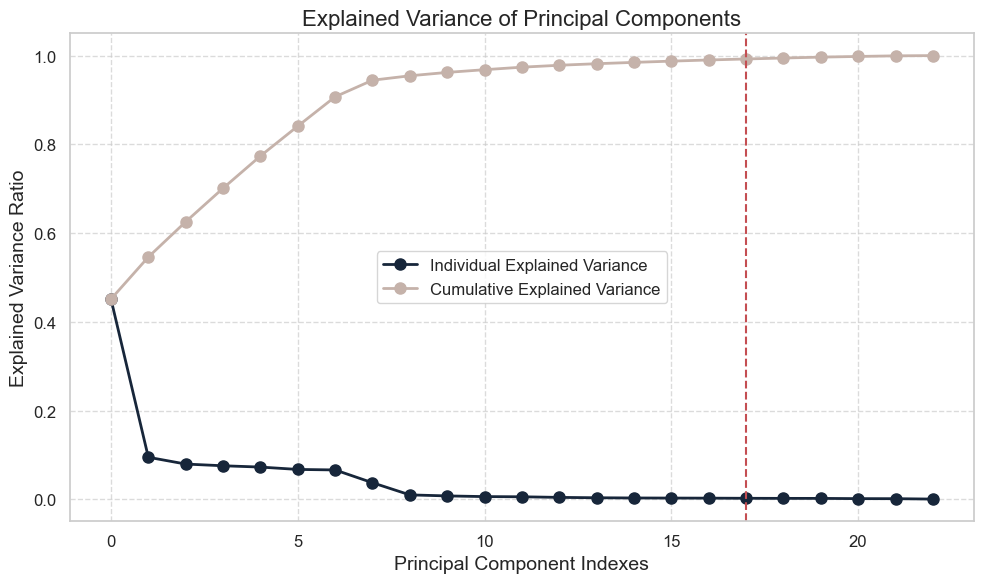

In [42]:
sns.set(style="whitegrid")
colors = ["#17263a", "#c5b2aa"]
plt.figure(figsize=(10, 6))

plt.plot(pca.explained_variance_ratio_, marker='o', color=colors[0], linewidth=2, markersize=8, label='Individual Explained Variance')

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color=colors[1], linewidth=2, markersize=8, label='Cumulative Explained Variance')

# Customize the appearance
plt.axvline(d, color='r', linestyle='--', linewidth=1.5)
plt.title('Explained Variance of Principal Components', fontsize=16)
plt.xlabel('Principal Component Indexes', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add tight layout and show the plot
plt.tight_layout()
plt.show()

As it seems like nearly 99 % of the variance in our dataset can be explained by the first 17 components, so to reduce our dimensionality, we will only choose these 17 components instead of all 22 to train our model.

In [43]:
pc = d
pca = PCA(n_components=pc)
pca.fit(X_train)

# Transform the training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert the transformed data to DataFrames and set column names
columns = [f'PC{i}' for i in range(1, pc + 1)]
X_train = pd.DataFrame(X_train_pca, columns=columns)
X_test = pd.DataFrame(X_test_pca, columns=columns)

## Helpful Functions

In [44]:
import requests

# Function to send a message to Telegram for updates so I can be afk while training models
#https://api.telegram.org/bot7615392112:AAH-3DQnNlUeBVjU4h0xp6q9QqK9qENlsqE/getUpdates
def send_telegram_message(message):
    bot_token = ''
    chat_id = ''
    url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    params = {
        'chat_id': chat_id,
        'text': message
    }

    response = requests.post(url, params=params)
    if response.status_code == 200:
        print('Message sent successfully!')
    else:
        print(f'Failed to send message. Status code: {response.status_code}')

# Function to train, calibrate, and evaluate model
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    try:
        message = f"Started training {model_name} model using RandomizedSearchCV..."
        send_telegram_message(message)

        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=20,  # Number of parameter settings sampled (adjust as needed)
            scoring='f1',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,  # Use all cores for parallel processing
            random_state=42  # Ensures reproducibility
        )
        
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        best_score = random_search.best_score_

        # Train the model with best parameters
        best_model.fit(X_train, y_train)

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate precision, recall, f1-score
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

        # Print metrics for debugging
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        print(f"{model_name} Precision: {precision:.4f}")
        print(f"{model_name} Recall: {recall:.4f}")
        print(f"{model_name} F1 Score: {f1:.4f}")

        # Send precision, recall, f1 score, and accuracy to Telegram
        metrics_message = f"""
        {model_name} Metrics:
        - Best Params: {best_params}
        - Best Cross-Validation Score: {best_score:.4f}
        - Accuracy: {accuracy:.4f}
        - Precision: {precision:.4f}
        - Recall: {recall:.4f}
        - F1 Score: {f1:.4f}
        """
        send_telegram_message(metrics_message)

        # Plot confusion matrix before calibration
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(cmap="cividis")
        plt.title(f'Confusion Matrix of {model_name} before calibration')
        plt.show()

        # Calibrate the model using prefit mode
        calib_model = CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
        calib_model.fit(X_train, y_train)

        # Make calibrated predictions
        y_calib_pred = calib_model.predict(X_test)

        # Calculate precision, recall, f1-score after calibration
        precision_calib, recall_calib, f1_calib, _ = precision_recall_fscore_support(y_test, y_calib_pred, average='binary')

        # Calculate accuracy after calibration
        accuracy_calib = accuracy_score(y_test, y_calib_pred)

        # Send calibrated metrics to Telegram
        calib_metrics_message = f"""
{model_name} Calibrated Metrics:
- Accuracy: {accuracy_calib:.4f}
- Precision: {precision_calib:.4f}
- Recall: {recall_calib:.4f}
- F1 Score: {f1_calib:.4f}
"""
        send_telegram_message(calib_metrics_message)

        # Plot calibration curve
        prob_true, prob_pred = calibration_curve(
            y_test, calib_model.predict_proba(X_test)[:, 1], n_bins=100
        )
        plt.figure(figsize=(5, 5))
        plt.plot(prob_pred, prob_true, marker='o', label=model_name)
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title(f'Calibration Plot for {model_name}')
        plt.legend()
        plt.show()

        # Plot confusion matrix after calibration
        cm = confusion_matrix(y_test, y_calib_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=calib_model.classes_)
        disp.plot(cmap="cividis")
        plt.title(f'Confusion Matrix of {model_name} after calibration')
        plt.show()

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, calib_model.predict_proba(X_test)[:, 1])
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, label=model_name)
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend()
        plt.show()

        # Return both the calibrated model and the best uncalibrated model
        return calib_model, best_model

    except Exception as e:
        # Send error message to Telegram
        error_message = f"Error occurred while training {model_name}: {str(e)}"
        send_telegram_message(error_message)
        print(error_message)
        return None, None


# Function to get TPR at a specific FPR threshold
def get_tpr_at_fpr(y_true, y_scores, fpr_threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    mask = fpr <= fpr_threshold
    if np.any(mask):
        tpr_at_fpr = tpr[mask][-1]
    else:
        tpr_at_fpr = 0.0
    return tpr_at_fpr


# Models

We can build a variety of models to predict credit card fraud. Amongst the modesl we will be looking at, there will be logistic regression, 


To optimize our models we use the following techniques:

#### Cross Validation
Cross Validation is a technique used to assess the performance of a machine learning model. It involves partitioning the dataset into a set of training and test subsets, and iteratively training and evaluating the model on these subsets. This method helps in determining how well the model generalizes to an independent dataset. One common approach is k-fold cross validation, where the data is divided into `k` subsets (folds), and the model is trained on `k-1` folds while the remaining fold is used for validation. This process is repeated `k` times, with each fold being used exactly once as the validation data. The final evaluation metric is typically the average of the metrics obtained in each fold. Cross validation helps in mitigating the overfitting problem by ensuring that the model performs well on different subsets of data.

#### Grid Search CV
Grid Search CV is a hyperparameter optimization technique used to find the best combination of hyperparameters for a machine learning model. It systematically works through multiple combinations of parameter tunes, cross-validates each combination, and determines which set of parameters works best. In Grid Search CV, a parameter grid is defined, specifying the hyperparameters and the values to be tried. The grid search then evaluates all possible combinations of these hyperparameters using cross-validation. For each combination, the model is trained and validated multiple times (usually using k-fold cross-validation) to ensure that the hyperparameters generalize well to unseen data. The combination with the best cross-validation score is selected as the optimal set of hyperparameters. Grid Search CV is an exhaustive search method and can be computationally expensive, but it ensures that the best possible hyperparameter set is found within the specified grid. 

## Metric to Optimize (f1)
We use the f1 score instead of accuracy as our metric of choice for scoring because in binary classification problems, especially when dealing with imbalanced datasets, the F1 score is a crucial metric because it balances both precision and recall. When the dataset is imbalanced (as is the case for our dataset), accuracy can be misleading because a model could predict the majority class most of the time and still achieve high accuracy. However, this wouldn't be useful if the minority class is of greater interest.

The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both concerns. It is particularly useful when you need to find an optimal balance between precision and recall, which is often the case in imbalanced datasets.

\[ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \]

By using the F1 score, you ensure that both false positives and false negatives are considered.

### Logistic Regression
Logistic regression is a powerful statistical method used in credit card fraud detection to classify transactions as either fraudulent or legitimate. In this context, logistic regression models the probability that a given transaction is fraudulent based on various features such as transaction amount, location, time, and user behavior. By applying a logistic (sigmoid) function to a weighted sum of these input features, the model outputs a probability score between 0 and 1, indicating the likelihood of fraud. This probability can then be used to make binary decisions, flagging transactions that exceed a certain threshold as potentially fraudulent. Logistic regression is favored in fraud detection due to its simplicity and interpretability

Failed to send message. Status code: 404
Logistic Regression Accuracy: 0.7905
Logistic Regression Precision: 0.5244
Logistic Regression Recall: 0.4585
Logistic Regression F1 Score: 0.4892
Failed to send message. Status code: 404


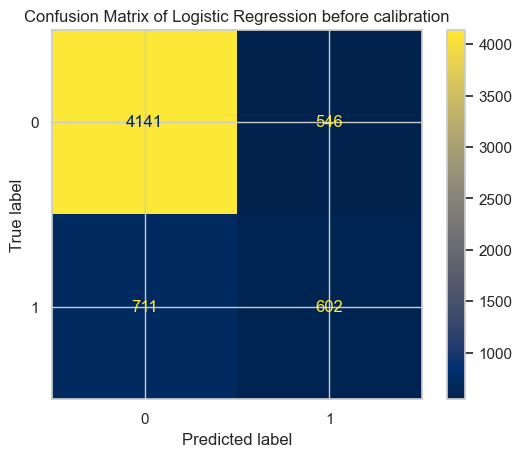

Failed to send message. Status code: 404


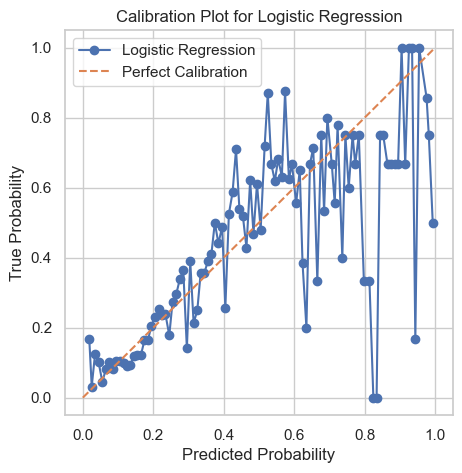

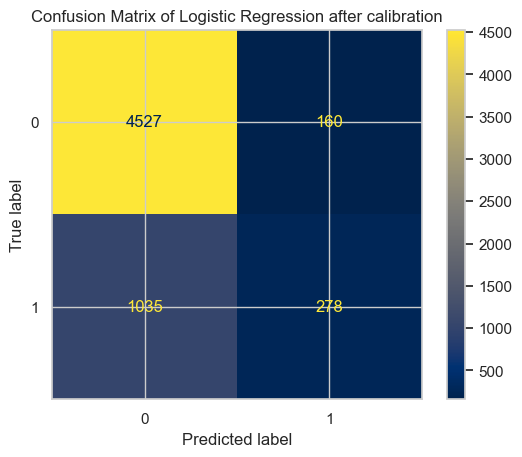

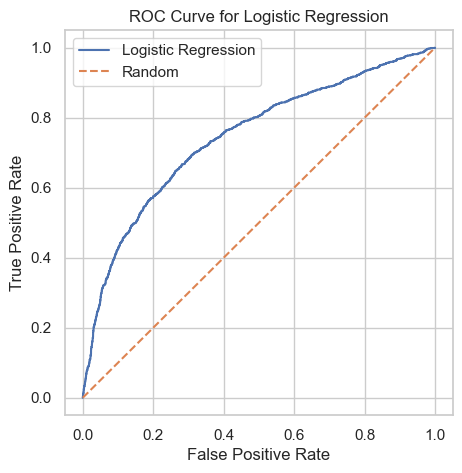

Feature 1: -0.04771311200240964
Feature 2: -0.05279112514567054
Feature 3: 0.03631765906917789
Feature 4: 0.15988069593793808
Feature 5: -0.06157090388109382
Feature 6: 0.004533069927028856
Feature 7: -0.03272570886767259
Feature 8: -0.045994474544470115
Feature 9: -0.03468423415472532
Feature 10: 0.01718737568244733
Feature 11: 0.0491256106946866
Feature 12: 0.0058161932537376965
Feature 13: -0.0074053408510241295
Feature 14: -0.0022679385615116576
Feature 15: -0.021584554034962546
Feature 16: -0.004832441791788339
Feature 17: 0.00129976255166987
Feature importance: [0.04771311 0.05279113 0.03631766 0.1598807  0.0615709  0.00453307
 0.03272571 0.04599447 0.03468423 0.01718738 0.04912561 0.00581619
 0.00740534 0.00226794 0.02158455 0.00483244 0.00129976]


In [45]:
# Logistic Regression
logit = LogisticRegression()
param_grid_logit = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300],
}

# Train and calibrate model; retrieve both models
logi_calib_model, best_logit = train_and_evaluate_model(
    logit, param_grid_logit, X_train, Y_train, X_test, Y_test, "Logistic Regression"
)

# Extract coefficients from the best uncalibrated model
if best_logit is not None:
    coefficients = best_logit.coef_[0]
    for i, coef in enumerate(coefficients):
        print(f"Feature {i+1}: {coef}")

    feature_importance = np.abs(coefficients)
    print(f"Feature importance: {feature_importance}")

The logistic regression model was evaluated using accuracy, precision, recall, and F1-score. The model achieved a best cross-validation score of 0.8105 with 10-fold cross-validation.

The logistic regression model performs well in predicting non-default cases, as evidenced by the high precision and recall for class 0. However, it struggles with predicting default cases, as indicated by the low recall for class 1. Further improvements are needed to enhance the detection of default cases.

### Random Forest

Random Forest is an ensemble learning method used for classification, regression, and other tasks. It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. The method combines the simplicity of decision trees with the flexibility of bagging, where subsets of data and features are randomly sampled to build each tree. This process helps to improve predictive accuracy and control over-fitting by reducing the variance component of the model's prediction error. Random Forests are widely used due to their robustness, ability to handle large datasets with higher dimensionality, and effectiveness in providing feature importance estimates.



In [46]:
# Random Forest
rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}


rf_calib_model = train_and_evaluate_model(
    rf, param_grid_rf, X_train, Y_train, X_test, Y_test, "Random Forest"
)

Failed to send message. Status code: 404


KeyboardInterrupt: 

## Boosting 
Boosting is an ensemble learning technique that sequentially trains weak models, like shallow decision trees, to correct the errors of previous models. This process reduces bias and builds a strong classifier by focusing on difficult cases. Random Forest, another ensemble method, reduces variance by averaging predictions from multiple decision trees trained on different data subsets. Combining boosting with Random Forest can enhance model performance by leveraging Random Forest's robustness and boosting's accuracy improvement, resulting in higher accuracy and better generalization in various predictive tasks.['Read More Here'](https://www.cs.cornell.edu/courses/cs578/2005fa/CS578.bagging.boosting.lecture.pdf)

## Gradient Boosting 

Message sent successfully!
Gradient Boosting Accuracy: 0.8123
Gradient Boosting Precision: 0.6238
Gradient Boosting Recall: 0.3587
Gradient Boosting F1 Score: 0.4555
Message sent successfully!


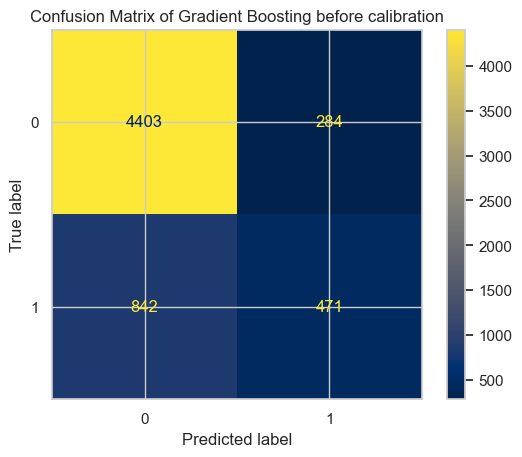

Message sent successfully!


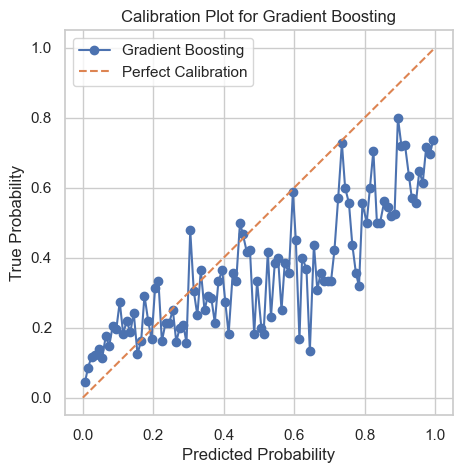

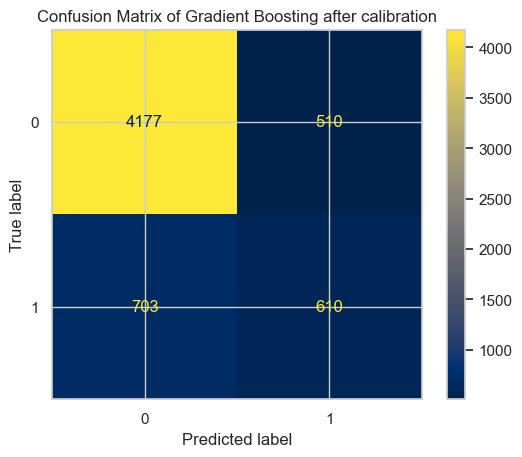

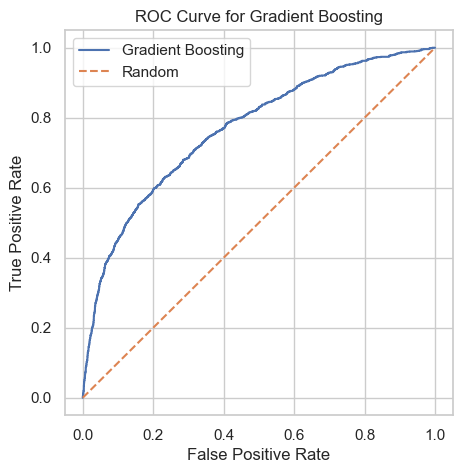

In [ ]:
# USe a Gradient Boosting Decision Tree model
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier()

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2'],  # Remove 'auto'
    'subsample': [0.8, 1.0],
}

# Train and evaluate Gradient Boosting model
gb_calib_model = train_and_evaluate_model(
    gb, param_grid_gb, X_train, Y_train, X_test, Y_test, "Gradient Boosting"
)

### XGBoost
XGBoost is a popular model for that is an efficient and scalable implementation of gradient boosting, often used in machine learning competitions for its high performance.

Message sent successfully!
XGBoost Accuracy: 0.8135
XGBoost Precision: 0.6307
XGBoost Recall: 0.3564
XGBoost F1 Score: 0.4555
Message sent successfully!


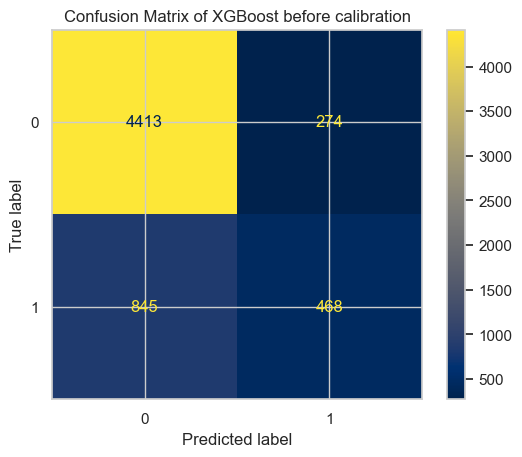

Message sent successfully!


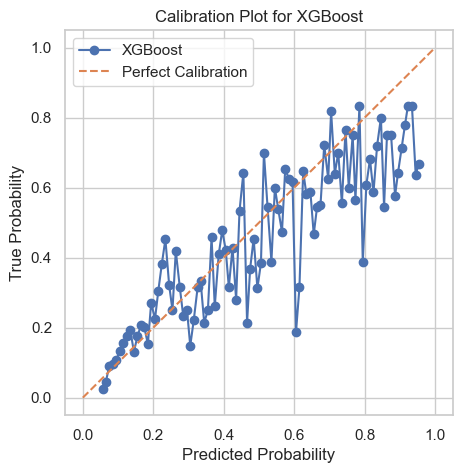

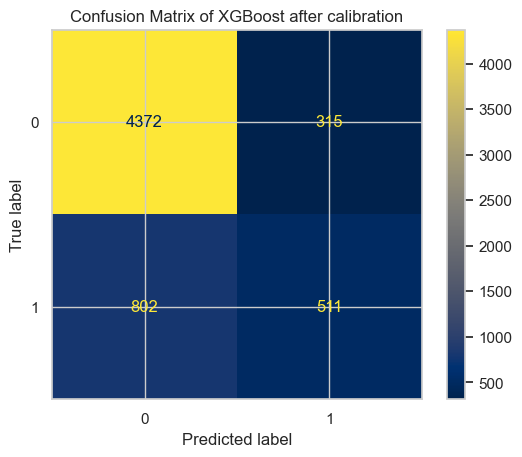

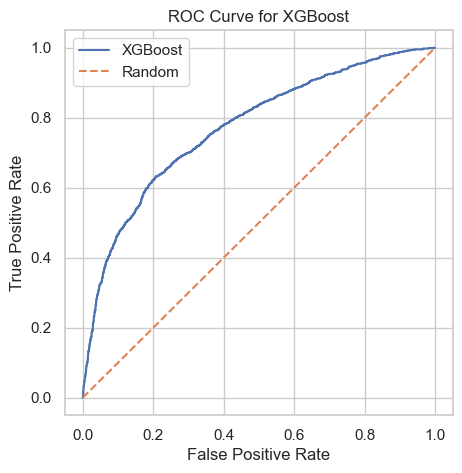

In [ ]:
xgboost = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgboost_calib_model = train_and_evaluate_model(
    xgboost, param_grid, X_train, Y_train, X_test, Y_test, "XGBoost"
)


### ADABoost

AdaBoost, short for Adaptive Boosting, is an ensemble learning technique that combines the outputs of multiple weak learners, typically decision stumps, to create a strong classifier. The key idea behind AdaBoost is to sequentially train weak classifiers, each one focusing on the errors made by the previous classifiers. During each iteration, AdaBoost adjusts the weights of incorrectly classified instances, giving them more importance in the next training round. This process continues until the desired number of weak classifiers is reached. 

AdaBoost should theoretically work better for our instance because it focuses on the mistakes made by previous classifiers, allowing it to improve the performance incrementally with each iteration. In our specific dataset, where some classes or features might be more challenging to classify correctly, AdaBoost's adaptive nature helps in fine-tuning the model by emphasizing these harder-to-classify instances. This iterative re-weighting process ensures that the model pays more attention to the difficult cases, which can lead to better overall accuracy and robustness. Additionally, since AdaBoost combines the outputs of multiple weak classifiers, it can reduce the risk of overfitting compared to a single, more complex model, making it a suitable choice for our classification task.

Message sent successfully!
AdaBoost Accuracy: 0.8000
AdaBoost Precision: 0.5946
AdaBoost Recall: 0.2704
AdaBoost F1 Score: 0.3717
Message sent successfully!


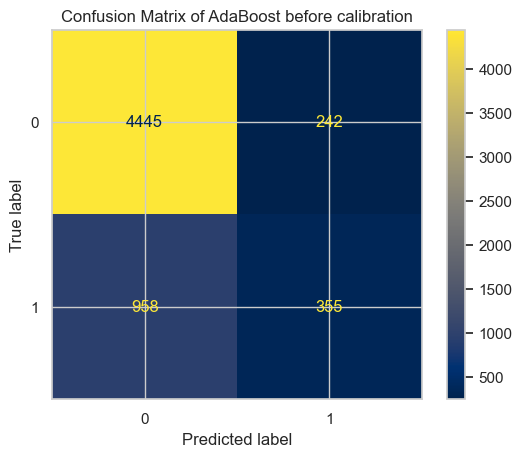

Message sent successfully!


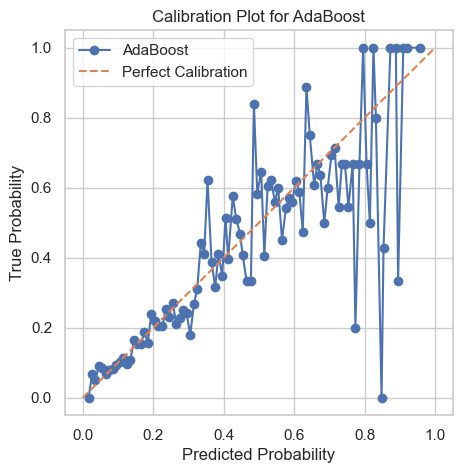

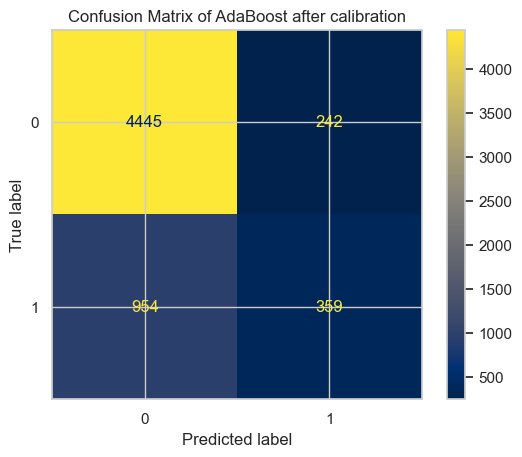

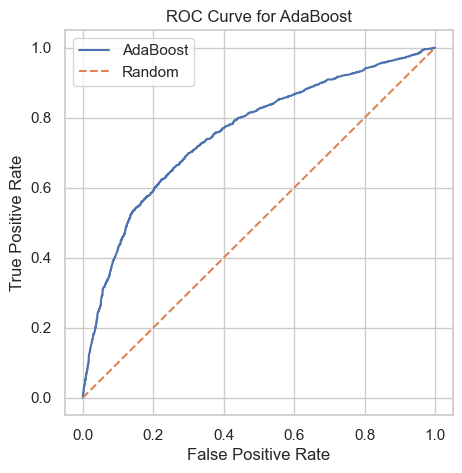

In [ ]:
# Initialize AdaBoost model
ada = AdaBoostClassifier()

# Parameter grid for AdaBoost

param_grid_ada = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME']
}


# Train and evaluate AdaBoost model
ada_calib_model = train_and_evaluate_model(
    ada, param_grid_ada, X_train, Y_train, X_test, Y_test, "AdaBoost"
)

## Conclusions



### ROC Curves

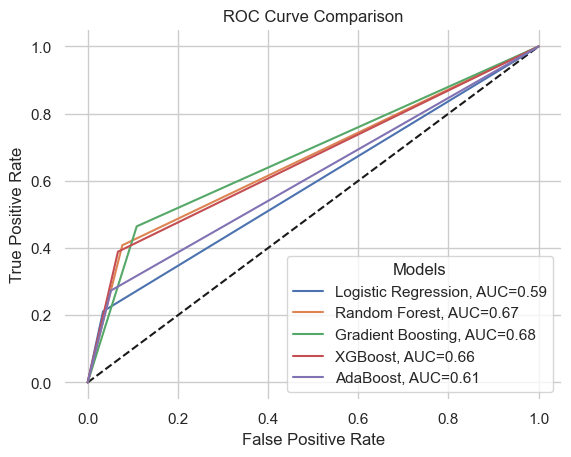

In [ ]:
# Make predictions on the test set
pred_logit = logi_calib_model.predict(X_test)
pred_rf = rf_calib_model.predict(X_test)
pred_gb = gb_calib_model.predict(X_test)
pred_xgb = xgboost_calib_model.predict(X_test)
pred_ada = ada_calib_model.predict(X_test)

# Print model accuracy and classification reports
models = {
    "Logistic Regression": (logi_calib_model, pred_logit),
    "Random Forest": (rf_calib_model, pred_rf),
    "Gradient Boosting": (gb_calib_model, pred_gb),
    "XGBoost": (xgboost_calib_model, pred_xgb),
    "AdaBoost": (ada_calib_model, pred_ada)
}

# ROC curve comparison
plt.plot([0, 1], [0, 1], 'k--')

for name, (model, preds) in models.items():
    fpr, tpr, _ = roc_curve(Y_test, preds)
    auc = roc_auc_score(Y_test, preds)
    plt.plot(fpr, tpr, label=f"{name}, AUC={auc:.2f}")

plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.box(False)
plt.show()

The Gradient Boosting model achieved the highest AUC scores of 0.68, indicating its ability to balance sensitivity (true positive rate) and specificity (true positive rate). Random Forest and XGBoost closely followed with an AUC score of 0.67 and 0.66 respectively, while the Logistic Regression model had a lower AUC score of 0.59. Despite the slight variations, the Gradient Boosting, Random Forest, and XGBoost models demonstrated comparable and higher AUC scores, making them more reliable for this classification task compared to Logistic Regression and AdaBoost.

### F1-Scores

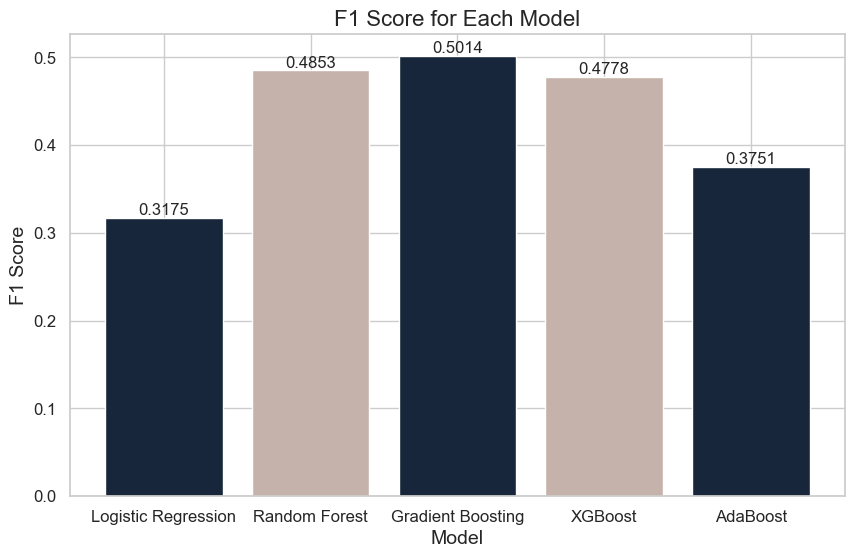

In [ ]:
from sklearn.metrics import f1_score
# Plot the f1 score for each model
f1_scores = [f1_score(Y_test, preds) for _, (_, preds) in models.items()]
models_names = list(models.keys())

#label each bar with the f1 score
plt.figure(figsize=(10, 6))
plt.bar(models_names, f1_scores, color=['#17263a', '#c5b2aa'])
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1, f'{f1:.4f}', ha='center', va='bottom', fontsize=12)

plt.title('F1 Score for Each Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



After evaluating multiple machine learning models on our dataset, including Logistic Regression, Gradient Boosting, Random Forest, XGBoost, and AdaBoost, we find that the Gradient Boosting model performs the best. The Gradient Boosting model achieved an f1-score of 0.5014 on the test set, which is the highest among all the models tested. This result is closely followed by the Random Forest model, with an f1 of 0.4853, and the XGBoost model at 0.4778.

Based on these results, using the Gradient Boosting model for this classification task seems the best if optimal accuracy is required, as it provides the highest f1-score and is well-suited for the given data characteristics. However if time constraints are an issue, then using XGBoost would be more appropriate as it took way less time to complete compared to the Gradient Boosting model.